In [1]:
import pickle
import scipy
from hashlib import sha256
from pathlib import Path
from typing import Sequence

import numpy as np
from matplotlib import pyplot as plt

from src.functions.__const__ import HASH_LENGTH
from src.plot_scripts.common import get_parameters
from z_outputs.plots import get_plots_path
from z_outputs.results import get_results_path
from z_outputs.cache import get_cache_path, set_cache_path

In [2]:
basepath = get_results_path()
# slurm_id = 2041250
# basepath = Path(rf"/scratch/slurm-{slurm_id}")
# set_cache_path(Path(rf"/scratch/slurm-{slurm_id}/cache"))

In [3]:
location = basepath / "simulation_3_868d1548_11110.sqlite"
location = Path(location)
is_reciprocal = location.stem.split("_")[3][1] != "0"
print(f"is_reciprocal: {is_reciprocal}")

is_reciprocal: True


In [4]:
parameters = {
    "coupling": "properties|::Root Element::R_1|coupling",
    "phase": "properties|::Root Element::R_1|phase",
    "t_1": "results|::Root Element::OSA_R_1_rt|mode 1/signal|values",
    "t_2": f"results|::Root Element::OSA_R_1_{'lb' if is_reciprocal else 'rb'}|mode 1/signal|values",
    "f_1": "results|::Root Element::OSA_R_1_rt|mode 1/signal|Frequency",
    "f_2": f"results|::Root Element::OSA_R_1_{'lb' if is_reciprocal else 'rb'}|mode 1/signal|Frequency",
}

In [5]:
parameters = get_parameters(location, parameters, False)

Loaded 'properties|::Root Element::R_1|coupling' from '/ix/nyoungblood/vis77/Through-Port-Ring-Resonators/z_outputs/cache/simulation_3_868d1548_11110_9efcf18d.pkl'
Loaded 'properties|::Root Element::R_1|phase' from '/ix/nyoungblood/vis77/Through-Port-Ring-Resonators/z_outputs/cache/simulation_3_868d1548_11110_cb588602.pkl'
Loaded 'results|::Root Element::OSA_R_1_rt|mode 1/signal|values' from '/ix/nyoungblood/vis77/Through-Port-Ring-Resonators/z_outputs/cache/simulation_3_868d1548_11110_70701269.pkl'
Loaded 'results|::Root Element::OSA_R_1_lb|mode 1/signal|values' from '/ix/nyoungblood/vis77/Through-Port-Ring-Resonators/z_outputs/cache/simulation_3_868d1548_11110_474d3cca.pkl'
Loaded 'results|::Root Element::OSA_R_1_rt|mode 1/signal|Frequency' from '/ix/nyoungblood/vis77/Through-Port-Ring-Resonators/z_outputs/cache/simulation_3_868d1548_11110_eebcd579.pkl'
Loaded 'results|::Root Element::OSA_R_1_lb|mode 1/signal|Frequency' from '/ix/nyoungblood/vis77/Through-Port-Ring-Resonators/z_outpu

In [6]:
phi_shift = (np.pi / 2) if is_reciprocal else (np.pi / 4)
phi_limits = (0, np.pi) if is_reciprocal else (-np.pi / 2, np.pi / 2)

all_phases = np.unique(parameters["phase"])
using_phi_shift = all_phases[np.argmin(np.abs(all_phases - phi_shift))]
print(f"Phase range: [{np.min(all_phases)}, {np.max(all_phases)}]")
print(f"Using phase shift: {using_phi_shift}")

coupling = 0.1
all_coupling = np.unique(parameters["coupling"])
using_coupling = all_coupling[np.argmin(np.abs(all_coupling - coupling))]
coupling_phi_index = np.where((parameters["coupling"] == using_coupling) & (parameters["phase"] == using_phi_shift))[0][0]
print(f"Coupling range: [{np.min(all_coupling)}, {np.max(all_coupling)}]")
print(f"Using coupling: {using_coupling}")
print(f"Using coupling_phi_index: {coupling_phi_index}")

Phase range: [0.0, 3.14159265359]
Using phase shift: 1.545863051767
Coupling range: [0.0, 0.2]
Using coupling: 0.101587301587
Using coupling_phi_index: 2016


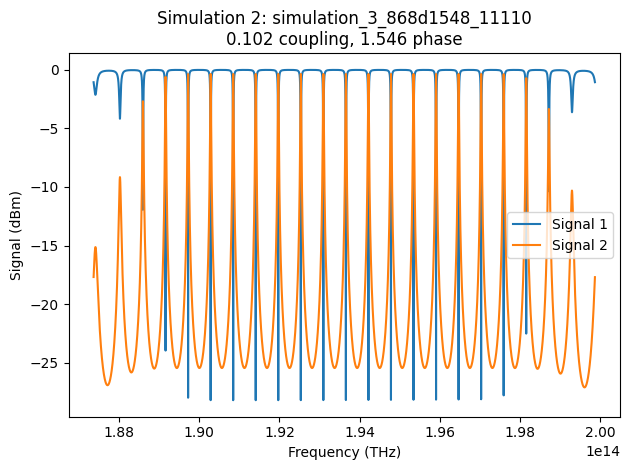

In [7]:
fig, ax = plt.subplots(1, 1)
ax.plot(parameters["f_1"][coupling_phi_index], parameters["t_1"][coupling_phi_index], label="Signal 1")
ax.plot(parameters["f_2"][coupling_phi_index], parameters["t_2"][coupling_phi_index], label="Signal 2")
ax.set_xlabel("Frequency (THz)")
ax.set_ylabel("Signal (dBm)")
ax.set_title(
    f"Simulation 2: {location.stem}\n"
    f"{parameters['coupling'][coupling_phi_index]:.3f} coupling, "
    f"{parameters['phase'][coupling_phi_index]:.3f} phase"
)
ax.legend()
plt.tight_layout()
plt.savefig(get_plots_path() / f"{location.stem}_frequency_{int(coupling * 10)}_{int(using_phi_shift * 10 / np.pi)}.png", dpi=600)
plt.show()
plt.close(fig)

In [8]:
frequency = 3e8 / 1550e-9
signal_1_on_index = np.array(parameters["t_1"][coupling_phi_index])
freq_on_index = np.array(parameters["f_1"][coupling_phi_index])
peaks = np.where(signal_1_on_index < (np.min(signal_1_on_index) * 0.9))[0]
freq_of_peaks = freq_on_index[peaks]
using_freq = freq_of_peaks[np.argmin(np.abs(freq_of_peaks - frequency))]
freq_index = peaks[np.argmin(np.abs(freq_of_peaks - frequency))]

print(f"Using frequency (probe at): {3e8 * 1e9 / using_freq:.3f} nm or {using_freq * 1e-12:.3f} THz")
print(f"Using index: {freq_index}")

Using frequency (probe at): 1549.139 nm or 193.656 THz
Using index: 50320


In [9]:
freq_1545 = np.argmin(np.abs(freq_on_index - 3e8 / 1545e-9))
freq_1555 = np.argmin(np.abs(freq_on_index - 3e8 / 1555e-9))
new_freq = freq_on_index[freq_1555:freq_1545]

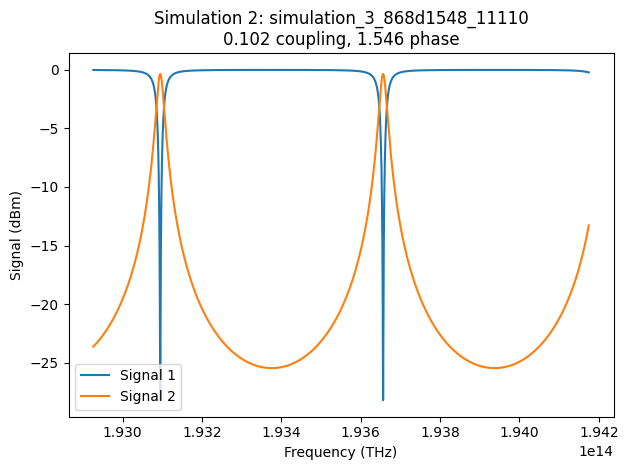

In [10]:
fig, ax = plt.subplots(1, 1)
ax.plot(parameters["f_1"][coupling_phi_index][freq_1555:freq_1545], parameters["t_1"][coupling_phi_index][freq_1555:freq_1545], label="Signal 1")
ax.plot(parameters["f_2"][coupling_phi_index][freq_1555:freq_1545], parameters["t_2"][coupling_phi_index][freq_1555:freq_1545], label="Signal 2")
ax.set_xlabel("Frequency (THz)")
ax.set_ylabel("Signal (dBm)")
ax.set_title(f"Simulation 2: {location.stem}\n{parameters['coupling'][coupling_phi_index]:.3f} coupling, {parameters['phase'][coupling_phi_index]:.3f} phase")
ax.legend()
plt.tight_layout()
plt.show()
plt.close(fig)

In [11]:
new_parameters = {
    "coupling": parameters["coupling"],
    "phase": parameters["phase"],
    "signal_1": [],
    "signal_2": [],
    "frequencies": new_freq,
}

if isinstance(parameters["t_1"], np.ndarray):
    parameters["t_1"] = parameters["t_1"].tolist()
if isinstance(parameters["t_2"], np.ndarray):
    parameters["t_2"] = parameters["t_2"].tolist()
    
for i in range(len(parameters["coupling"])):
    if isinstance(parameters["t_1"][i], Sequence):
        new_parameters["signal_1"].append(parameters["t_1"][i][freq_1555:freq_1545])
    else:
        new_parameters["signal_1"].append([parameters["t_1"][i]] * len(new_freq))
    if isinstance(parameters["t_2"][i], Sequence):
        new_parameters["signal_2"].append(parameters["t_2"][i][freq_1555:freq_1545])
    else:
        new_parameters["signal_2"].append([parameters["t_2"][i]] * len(new_freq))

new_parameters["signal_1"] = np.array(new_parameters["signal_1"])
new_parameters["signal_2"] = np.array(new_parameters["signal_2"])
print(f"signal_1 Shape: {new_parameters['signal_1'].shape}")
print(f"signal_2 Shape: {new_parameters['signal_2'].shape}")

signal_1 Shape: (4096, 9996)
signal_2 Shape: (4096, 9996)


In [12]:
# coupling_08_10 = np.where((new_parameters['coupling'] >= 0.8) & (new_parameters['coupling'] <= 1) & (new_parameters["phase"] >= phi_limits[0]) & (new_parameters["phase"] <= phi_limits[1]))
# new_parameters_08_10 = {
#     "coupling": new_parameters['coupling'][coupling_08_10],
#     "phase": new_parameters["phase"][coupling_08_10],
#     "signal_1": new_parameters["signal_1"][coupling_08_10],
#     "signal_2": new_parameters["signal_2"][coupling_08_10],
#     "frequencies": new_parameters["frequencies"],
# }
# coupling_00_02 = np.where((new_parameters['coupling'] >= 0) & (new_parameters['coupling'] <= 0.2) & (new_parameters["phase"] >= phi_limits[0]) & (new_parameters["phase"] <= phi_limits[1]))
# new_parameters_00_02 = {
#     "coupling": new_parameters['coupling'][coupling_00_02],
#     "phase": new_parameters["phase"][coupling_00_02],
#     "signal_1": new_parameters["signal_1"][coupling_00_02],
#     "signal_2": new_parameters["signal_2"][coupling_00_02],
#     "frequencies": new_parameters["frequencies"],
# }
# scipy.io.savemat("simulation_" + ("reciprocal" if is_reciprocal else "non_reciprocal") + "_08_10.mat", new_parameters_08_10)
# scipy.io.savemat("simulation_" + ("reciprocal" if is_reciprocal else "non_reciprocal") + "_00_02.mat", new_parameters_00_02)

coupling_mini = [True, False, False, False] * (new_parameters['coupling'].shape[0] // (4 * 2))
coupling_mini = coupling_mini + list(reversed(coupling_mini))
coupling_mini = np.array(coupling_mini)
new_parameters_mini = {
    "coupling": new_parameters['coupling'][coupling_mini],
    "phase": new_parameters["phase"][coupling_mini],
    "signal_1": new_parameters["signal_1"][coupling_mini],
    "signal_2": new_parameters["signal_2"][coupling_mini],
    "frequencies": new_parameters["frequencies"],
}
scipy.io.savemat("simulation_" + ("reciprocal" if is_reciprocal else "non_reciprocal") + "_mini.mat", new_parameters_mini)
scipy.io.savemat("simulation_" + ("reciprocal" if is_reciprocal else "non_reciprocal") + ".mat", new_parameters)
print("Done")

Done


In [13]:
er_p = np.array([np.nan] * len(parameters["coupling"]))

for i in range(len(parameters["coupling"])):
    if not isinstance(parameters["t_1"][i], Sequence):
        continue
    if not isinstance(parameters["t_2"][i], Sequence):
        continue
    er_p[i] = parameters["t_1"][i][freq_index] - parameters["t_2"][i][freq_index]


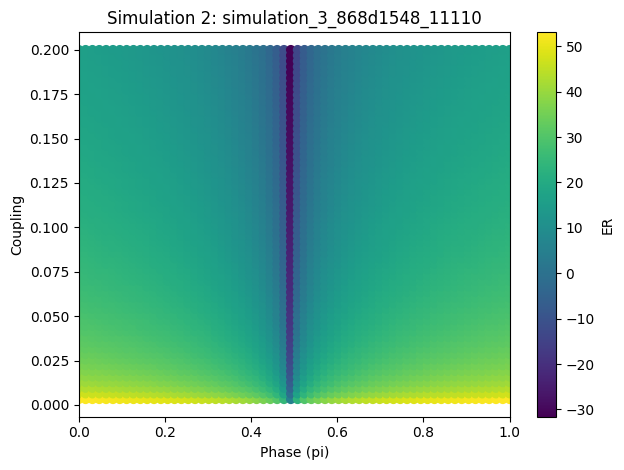

In [14]:
fig, ax = plt.subplots(1, 1)
sc = ax.scatter(parameters["phase"] / np.pi, parameters["coupling"], c=er_p)
cbar = plt.colorbar(sc)
cbar.set_label("ER")
ax.set_xlabel("Phase (pi)")
ax.set_ylabel("Coupling")
ax.set_title(f"Simulation 2: {location.stem}")
ax.set_xlim(phi_limits[0] / np.pi, phi_limits[1] / np.pi)
plt.tight_layout()
plt.savefig(get_plots_path() / f"{location.stem}_er.png", dpi=600)
plt.show()
plt.close(fig)

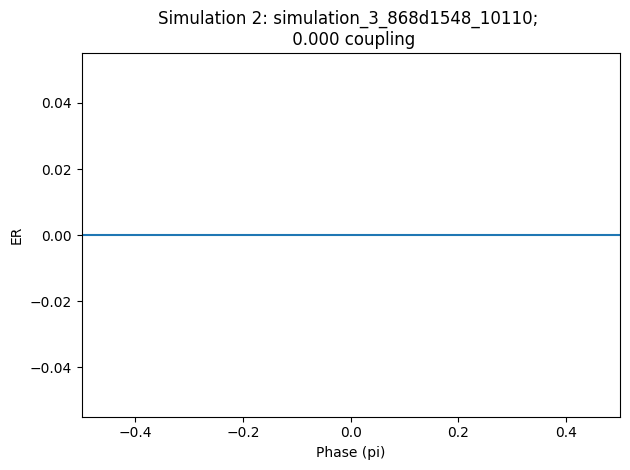

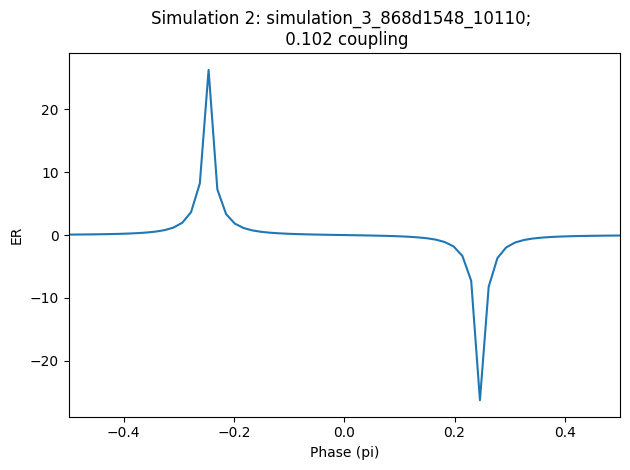

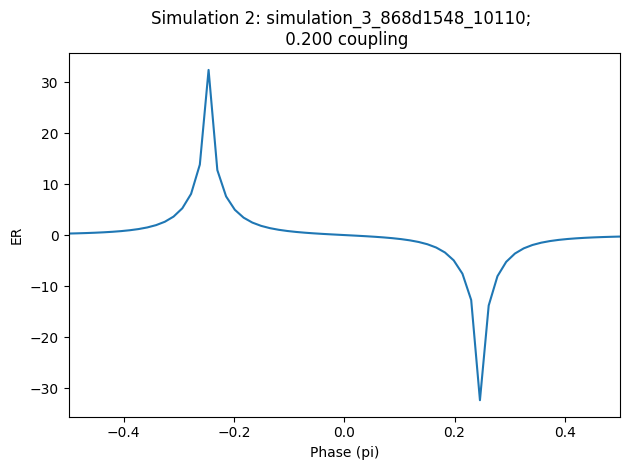

In [17]:
for i in range(int(np.min(parameters["coupling"]) * 10), int(np.max(parameters["coupling"]) * 10) + 1):
    plot_coupling = i / 10
    fig, ax = plt.subplots(1, 1)
    with_coupling = all_coupling[np.argmin(np.abs(all_coupling - plot_coupling))]
    indexes = parameters["coupling"] == with_coupling
    sc = ax.plot(parameters["phase"][indexes] / np.pi, er_p[indexes])
    ax.set_xlabel("Phase (pi)")
    ax.set_ylabel("ER")
    ax.set_title(f"Simulation 2: {location.stem}; \n {with_coupling:.3f} coupling")
    ax.set_xlim(phi_limits[0] / np.pi, phi_limits[1] / np.pi)
    plt.tight_layout()
    plt.savefig(get_plots_path() / f"{location.stem}_er_{int(with_coupling * 10)}.png", dpi=600)
    plt.show()
    plt.close(fig)